Task - Identify Intents on dataset

- what are the diffrent intents ?
- for each intent - find 3 examples


Approches:
 - Use Bert variation to generate embeddings then use clustering algorithem hoping to find diffrent groups (similar sentences would hopefully b grouped together)
 - Use Topic Modeling to understand the diffrent topics of conversation

# Setup -
libraries and such

In [2]:
!pip install pyLDAvis
# Install necessary libraries
!pip install transformers sentence-transformers umap-learn scikit-learn matplotlib pandas
!pip install keybert
! pip install sentence_transformers
!pip install yake
!pip install umap-learn
!pip install hdbscan
!pip install spacy
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 79.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Data
clean preprocess and explore

In [6]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Load the data
df = pd.read_csv('/content/sentences.csv')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function for text cleaning with lemmatization
def clean_text_with_lemmatization(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())  # Remove special characters and convert to lowercase
    words = nltk.word_tokenize(text)  # More accurate tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply cleaning to the 'sentence' column
df['cleaned_sentence'] = df['sentence'].apply(clean_text_with_lemmatization)

# Drop rows with empty cleaned sentences (if any)
df.dropna(subset=['cleaned_sentence'], inplace=True)

# Display the first few cleaned sentences
print(df[['sentence', 'cleaned_sentence']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                            sentence  \
0  You know, that should work perfectly. Let's re...   
1  That's great to hear. Can you provide more spe...   
2  Well, my wife and I both work from home, and w...   
3  Wait, so you're telling me that even if I pay ...   
4  I see. And how much does this service typicall...   

                                    cleaned_sentence  
0                 know work perfectly let reschedule  
1  thats great hear provide specific minimum focu...  
2  well wife work home need separate line busines...  
3  wait youre telling even pay caller id could st...  
4                    see much service typically cost  


# Clustering




## Sentence transformers

general idea - embedding generation and use clustering algorithem



- Generating Embeddings: 'all-MiniLM-L6-v2' ,'paraphrase-MiniLM-L12-v2', fine-tuned model
- Reducing Dimmensions:UMAP
- Clustering algorithems: HDBSACN, K-MEANS, GMM, AGG, DBSCAN, OPTICS
- Evaluation: Silhouette,Davies-Bouldin Score




In [2]:
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from collections import Counter

# Load a pre-trained sentence transformer model
model = SentenceTransformer('paraphrase-MiniLM-L12-v2')

# Generate embeddings for all sentences
df['sentence_embedding'] = df['cleaned_sentence'].apply(lambda x: model.encode(x))

# Convert the list of embeddings to a numpy array
embeddings = np.array(df['sentence_embedding'].tolist())

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [3]:
# Dimensionality reduction with UMAP
umap_reducer = umap.UMAP(n_components=5, random_state=42, metric='cosine')
reduced_embeddings = umap_reducer.fit_transform(embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


###K means

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# K-Means clustering
kmeans = KMeans(n_clusters=20, random_state=42)
df['k_cluster'] = kmeans.fit_predict(reduced_embeddings)

# Evaluate clustering quality
if len(set(df['k_cluster'])) > 1:
    silhouette_avg = silhouette_score(reduced_embeddings, df['k_cluster'])
    db_score = davies_bouldin_score(reduced_embeddings, df['k_cluster'])
    print(f"K-Means - Silhouette Score: {silhouette_avg}")
    print(f"K-Means - Davies-Bouldin Score: {db_score}")
else:
    print("Only one cluster found. Consider tuning K-Means parameters.")

# Count the number of sentences in each cluster
cluster_counts = df['k_cluster'].value_counts()
print(cluster_counts)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means - Silhouette Score: 0.3643476366996765
K-Means - Davies-Bouldin Score: 0.9107101375511146
k_cluster
14    6043
11    4052
10    3267
13    3252
7     3232
2     3067
0     2507
9     2429
15    2251
1     2250
5     1712
8     1332
6      872
3      721
4      372
17     346
19     301
12     167
18     148
16      72
Name: count, dtype: int64


In [5]:
# Function to print sample sentences from each cluster
def print_cluster_samples(df, cluster_label, num_samples=5):
    print(f"\nCluster {cluster_label} samples:")
    print(df[df['k_cluster'] == cluster_label]['cleaned_sentence'].head(num_samples).tolist())

# List of unique clusters
unique_clusters = df['k_cluster'].unique()

# Print samples from each cluster
for cluster in unique_clusters:
    print_cluster_samples(df, cluster)


Cluster 14 samples:
['know work perfectly let reschedule', 'calmer tone got thanks letting know getting worried missing due date service interrupted', 'yes ive tried multiple time error persists', 'sure rush', 'nothing changed end spontaneously happening']

Cluster 11 samples:
['thats great hear provide specific minimum focusing distance quality macro shot', 'alright restart tivo box', 'alright ive cleared cache rebooted like said apps still consistently freezing crashing annoying', 'ive tried everything changing battery resetting nothing seems work driving crazy', 'basically every app instagram gmail chrome name theyll open briefly immediately freeze crash super frustrating']

Cluster 9 samples:
['well wife work home need separate line business call video conference', 'sure one moment okay ran test showing download speed mbps upload speed mbps', 'hmm know im really sure data part basically use phone thing like email web browsing checking social medium kind thing', 'im paying month un


Cluster 84 samples:
['know work perfectly let reschedule', 'friday morning perfect ill home time slot great', 'saturday would perfect thats option ill home afternoon', 'okay perfect thank getting rescheduled', 'next tuesday pm would ideal']

Cluster 168 samples:
['thats great hear provide specific minimum focusing distance quality macro shot', 'hi im calling im interested new phone camera concern', 'yes hello recently purchased latest smartphone model im extremely dissatisfied camera performance', 'see mentioned dedicated night mode well', 'thats good know another concern lack optical zoom tell digital zoom capability']

Cluster -1 samples:
['well wife work home need separate line business call video conference', 'calmer tone got thanks letting know getting worried missing due date service interrupted', 'hi wondering could help understand internet usage feel like ive going data limit every month im sure', 'okay thats fine really frustrating able change channel access guide replacement

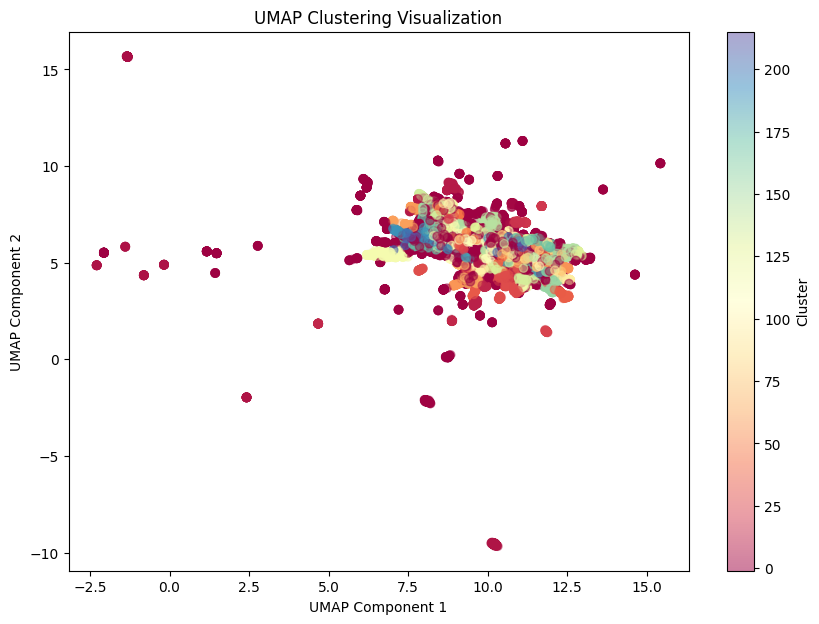

Noise (Cluster -1) sample sentences:
['well wife work home need separate line business call video conference', 'calmer tone got thanks letting know getting worried missing due date service interrupted', 'hi wondering could help understand internet usage feel like ive going data limit every month im sure', 'okay thats fine really frustrating able change channel access guide replacement necessary', 'yes hello im lot issue internet connection lately think might related router provided', 'nothing changed end spontaneously happening', 'okay think understand basic concept pricing option imagine ill need decent data allowance', 'would helpful also want assurance issue resolved promptly', 'hi recently received monthly bill noticed credit applied account im sure credit hoping could provide clarification', 'thats still quite expensive mean ill actually get service im paying ill consider']


In [ ]:

# Initialize KeyBERT for keyphrase extraction
keybert_model = KeyBERT('all-mpnet-base-v2')

# Load spaCy NER model
nlp = spacy.load("en_core_web_sm")

# Function to extract keyphrases using KeyBERT
def extract_keyphrases(text):
    keyphrases = keybert_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english')
    return keyphrases

# Function to identify the most representative sentence
def identify_intent(sentences, model):
    sentence_embeddings = model.encode(sentences)
    centroid = np.mean(sentence_embeddings, axis=0)
    distances = cosine_similarity([centroid], sentence_embeddings)
    closest_index = np.argmax(distances)
    return sentences[closest_index]

intents = []
for cluster in df['cluster'].unique():
    cluster_sentences = df[df['cluster'] == cluster]['sentence'].tolist()

    # Identify the most representative sentence
    representative_sentence = identify_intent(cluster_sentences, model)

    # Extract keyphrases using KeyBERT
    keyphrases = extract_keyphrases(representative_sentence)

    # Use spaCy NER to extract named entities
    doc = nlp(representative_sentence)
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Combine keyphrases and entities into an intent statement
    keyphrases_list = [kp[0] for kp in keyphrases]  # Extract only the keyphrase text
    entities_list = [ent[0] for ent in entities]  # Extract only the entity text

    # Create an intent statement using keyphrases and entities
    intent_statement = f"Keyphrases: {', '.join(keyphrases_list)} | Entities: {', '.join(entities_list)}"

    examples = ' | '.join(cluster_sentences[:3])  # Take up to 3 examples
    intents.append({'Intent': intent_statement, 'Examples': examples})

# Create a DataFrame for the results
result_df = pd.DataFrame(intents)

# Save the results to a CSV file
output_file = 'identified_intents.csv'
result_df.to_csv(output_file, index=False)

print(f'Results saved to {output_file}')


# Plot UMAP-reduced embeddings with cluster labels
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['cluster'], cmap='Spectral', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.title('UMAP Clustering Visualization')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

# Display a few sentences labeled as noise
noise_sentences = df[df['cluster'] == -1]['cleaned_sentence'].tolist()
print("Noise (Cluster -1) sample sentences:")
print(noise_sentences[:10])

# # Function to get common words in a cluster
# def get_common_words(df, cluster_label, num_words=10):
#     sentences = df[df['cluster'] == cluster_label]['cleaned_sentence']
#     words = ' '.join(sentences).split()
#     common_words = Counter(words).most_common(num_words)
#     return common_words

# # Display common words for each cluster
# for cluster in unique_clusters:
#     common_words = get_common_words(df, cluster)
#     print(f"Common words in cluster {cluster}: {common_words}")




# Topic modeling

## LDA +GridSearch

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.model_selection import GridSearchCV
from pprint import pprint



docs_preprocessed = df['cleaned_sentence']

# Vectorization using CountVectorizer
tf_vectorizer = CountVectorizer(strip_accents='unicode',
                                stop_words='english',
                                lowercase=True,
                                token_pattern=r'\b[a-zA-Z]{3,}\b',
                                max_df=0.5,
                                min_df=10)

dtm_tf = tf_vectorizer.fit_transform(docs_preprocessed)
print(f"TF DTM shape: {dtm_tf.shape}")

# Optimize number of topics using GridSearch
search_params = {'n_components': [5, 10, 15, 20], 'learning_decay': [0.5, 0.7, 0.9]}
lda = LatentDirichletAllocation(random_state=0)
model = GridSearchCV(lda, param_grid=search_params)
model.fit(dtm_tf)

# Best Model
best_lda_model = model.best_estimator_
print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(dtm_tf))

# LDA visualization
pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.lda_model.prepare(best_lda_model, dtm_tf, tf_vectorizer)
pyLDAvis.display(lda_vis)

# Display topics with clear format
def display_topics(lda_model, feature_names, no_top_words=10):
    topics = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics[topic_idx] = topic_words
        print(f"Topic {topic_idx}: {', '.join(topic_words)}")
    return topics

# Display topics in a human-readable format
tf_feature_names = tf_vectorizer.get_feature_names_out()
topics = display_topics(best_lda_model, tf_feature_names)

# Save topics to a CSV for easier inspection and manual mapping
topics_df = pd.DataFrame.from_dict(topics, orient='index', columns=[f'Word {i+1}' for i in range(10)])
topics_df.to_csv('identified_topics.csv', index_label='Topic Number')

print("\nTopics have been saved to 'identified_topics.csv' for easy inspection.")


TF DTM shape: (38393, 1971)
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -386445.77577501757
Model Perplexity:  437.9023342961344


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Topic 0: month, payment, need, account, fee, pay, yes, thats, right, received
Topic 1: plan, need, data, unlimited, channel, option, like, phone, message, calling
Topic 2: ive, customer, year, thats, really, possible, soon, need, battery, screen
Topic 3: thank, help, okay, ill, appreciate, alright, really, great, issue, try
Topic 4: number, account, yes, sure, technician, appointment, scheduled, michael, come, emily
Topic 5: ive, really, issue, internet, frustrating, yes, time, service, work, day
Topic 6: new, phone, calling, yes, service, hello, internet, need, home, cable
Topic 7: sound, okay, thats, fee, charge, good, like, cost, ahead, reasonable
Topic 8: address, street, yes, oak, state, email, usa, maple, sure, billing
Topic 9: service, internet, thats, dont, company, provider, cancel, ive, expect, want

Topics have been saved to 'identified_topics.csv' for easy inspection.


## Cleaned with lemmatization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the cleaned sentences
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_sentence'])

# Show shape of TF-IDF matrix
print("TF-IDF Matrix shape:", tfidf_matrix.shape)


from sklearn.decomposition import LatentDirichletAllocation

# Number of topics
n_topics = 20

# Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(tfidf_matrix)

# Display the topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda_model, tfidf_vectorizer.get_feature_names_out(), no_top_words)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TF-IDF Matrix shape: (38393, 3917)
Topic 0:
provider im service switching switch really thats port hi phone
Topic 1:
ive issue im tried really time internet frustrating connection multiple
Topic 2:
thank help appreciate okay great thanks taking ill assistance alright
Topic 3:
card security pro code number iphone battery expiration sim credit
Topic 4:
need checked hold termination im yes secondary early date hi
Topic 5:
order long password im email hi distance minute voicemail log
Topic 6:
plan sound unlimited option data thats cost like okay pricing
Topic 7:
number account yes sure michael davis thompson emily johnson sarah
Topic 8:
im new hi channel service phone tv need quality picture
Topic 9:
address street oak state usa maple yes cityville elm anytown
Topic 10:
thats expect credit caller okay mistake service happen better refund
Topic 11:
income higher sensor dont normal discounted im qualify case earliest
Topic 12:
paid month fee pay th late wasnt time im received
Topic 13:
work 

## pyLDAvis visualisation

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation


docs_raw = df['cleaned_sentence'].tolist()




tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5,
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(docs_raw)
print(dtm_tf.shape)

tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)
print(dtm_tfidf.shape)

import pyLDAvis
import pyLDAvis.lda_model


# Prepare LDA visualization
pyLDAvis.enable_notebook()


# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(dtm_tf)


# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(38393, 1971)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:2078: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


(38393, 1971)


LatentDirichletAllocation(n_components=20, random_state=0)

In [ ]:
pyLDAvis.lda_model.prepare(lda_tf, dtm_tf, tf_vectorizer)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5      0.085342 -0.256760       1        1  7.248333
3     -0.123137  0.073315       2        1  6.164544
11    -0.114254 -0.129061       3        1  6.164324
7     -0.243464  0.177748       4        1  6.054377
6      0.135551 -0.091417       5        1  5.968012
1     -0.064527  0.004505       6        1  5.664441
19     0.092671 -0.232513       7        1  5.400101
16     0.008763 -0.113432       8        1  5.369622
4      0.287655  0.229619       9        1  5.126068
0     -0.165379  0.093888      10        1  4.835123
9     -0.063499 -0.086380      11        1  4.730340
18     0.093843  0.024226      12        1  4.600638
10     0.026913 -0.157949      13        1  4.498239
15     0.115074 -0.077155      14        1  4.436510
14     0.018546  0.204004      15        1  4.429674
12    -0.191728  0.113255      16        1  4.364096
13     0.061698  0.008466      17        1  4.157706
17    -0.178646  0.010366      18        1  3.979087
8      0.304576  0.221350      19        1  3.772065
2     -0.085999 -0.016074      20        1  3.036701, topic_info=         Term         Freq        Total Category  logprob  loglift
17    account  3961.000000  3961.000000  Default  30.0000  30.0000
1130   number  3752.000000  3752.000000  Default  29.0000  29.0000
1726    thank  2294.000000  2294.000000  Default  28.0000  28.0000
1597    sound  2084.000000  2084.000000  Default  27.0000  27.0000
1241     plan  2862.000000  2862.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1944  working   115.440975   847.738209  Topic20  -4.3796   1.5006
496    doesnt    86.114753   714.976093  Topic20  -4.6727   1.3778
649      fine    73.042298   641.384970  Topic20  -4.8373   1.3218
954      like    80.018702  2134.812146  Topic20  -4.7461   0.2105
724      good    74.280952  1149.998710  Topic20  -4.8205   0.7547

[1320 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2         1  0.191072  able
2         3  0.024727  able
2         6  0.004496  able
2         8  0.170841  able
2        11  0.017983  able
...     ...       ...   ...
1967      3  0.981799  zero
1968     19  0.993689   zip
1969      4  0.966112  zone
1969     12  0.020339  zone
1970     14  0.938332  zoom

[2761 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 12, 8, 7, 2, 20, 17, 5, 1, 10, 19, 11, 16, 15, 13, 14, 18, 9, 3])

In [ ]:
pyLDAvis.lda_model.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12     0.099824 -0.227160       1        1  7.122352
11     0.119876  0.074607       2        1  6.736344
5      0.091255  0.200208       3        1  6.651984
3      0.031712 -0.045604       4        1  6.503226
9      0.105997 -0.108283       5        1  5.816208
4     -0.401306  0.003146       6        1  5.069840
19     0.056348  0.223491       7        1  4.883170
0      0.033144 -0.102357       8        1  4.812511
10     0.076937  0.162328       9        1  4.723965
14     0.003707  0.066911      10        1  4.690416
8     -0.428345  0.019868      11        1  4.653148
16     0.065363  0.061039      12        1  4.627721
1      0.070005 -0.099797      13        1  4.603511
18     0.005532 -0.112646      14        1  4.450421
7      0.019640 -0.191618      15        1  4.348836
15    -0.044227  0.023207      16        1  4.345254
13    -0.010891 -0.096009      17        1  4.289676
6      0.038616  0.111541      18        1  4.204593
17     0.049130 -0.043838      19        1  3.925595
2      0.017682  0.080966      20        1  3.541228, topic_info=         Term         Freq        Total Category  logprob  loglift
1130   number  1205.000000  1205.000000  Default  30.0000  30.0000
17    account  1149.000000  1149.000000  Default  29.0000  29.0000
1726    thank   674.000000   674.000000  Default  28.0000  28.0000
1646   street   344.000000   344.000000  Default  27.0000  27.0000
37    address   481.000000   481.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
649      fine    34.813583   228.844818  Topic20  -4.6200   1.4577
1866    using    29.643203   152.741115  Topic20  -4.7807   1.7012
1728    thats    31.109558   888.034842  Topic20  -4.7325  -0.0108
1960      yes    30.398375  1605.114347  Topic20  -4.7556  -0.6259
1099     need    29.534688   978.745265  Topic20  -4.7844  -0.1600

[1302 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         2  0.706141  ability
1         3  0.145382  ability
1         7  0.145382  ability
2         2  0.182828     able
2         3  0.168202     able
...     ...       ...      ...
1960     20  0.018690      yes
1962      2  0.967029     youd
1968     11  0.981043      zip
1969     14  0.964567     zone
1970     16  0.858970     zoom

[3817 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 12, 6, 4, 10, 5, 20, 1, 11, 15, 9, 17, 2, 19, 8, 16, 14, 7, 18, 3])